## Environment setup

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu Nov 30 14:44:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!unzip "/content/drive/MyDrive/projects/my_final_project/fig_brh35_dataset/detr_dataset/detr_dataset.zip" -d "/content/drive/MyDrive/projects/my_final_project/fig_brh35_dataset/detr_dataset"

In [ ]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.1
!pip install -q -U transformers
!pip install -q -U pytorch-lightning
!pip install -q  -U  timm

Looking in indexes: https://test.pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00


# Imports

In [ ]:
#import some necessary librairies
import os
import random
import os.path
from pathlib import Path
import warnings
import itertools
from warnings import filterwarnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore all warning  message from librairies

# linear algebra
import numpy as np
# data processing
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import transformers
import pytorch_lightning
import os
import timm
from transformers import DetrConfig, DetrForObjectDetection,DetrFeatureExtractor#,DetrTimmConvEncoderوDetrImageProcessor
import torchvision
import cv2
import supervision as sv
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch
from torch.nn import CrossEntropyLoss

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


print(
    "; supervision:", sv.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
; supervision: 0.3.1 ; transformers: 4.35.2 ; pytorch_lightning: 2.1.2


# Constants

In [ ]:
import os
import torch

PROJECT_NAME = "" #just for project title
RANDOM_SEED = 42

MAIN_PROJECT_PATH = "/content/drive/MyDrive/projects/my_final_project/04_detr_detection_model"
DATASET_PATH="/content/drive/MyDrive/projects/my_final_project/datasets/detr_dataset"

#DETR Config
MODEL_TRAIN_EPOCHS = 50
NUM_OF_CLASS = 4
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_NAMEL="detr_backbone_seresnet_model"
CHECKPOINT = 'facebook/detr-resnet-50'
BACKBONE="seresnet50"     #backbone to test ==> "densenet121", "cspresnet50"

DETR_ENCODERS_LAYERS = 6
DETR_DECODERS_LAYERS = 6
DETR_HEADS = 8
NUM_CLASSES = NUM_OF_CLASS
ACT_FUNC = "relu"


CONFIDENCE_TRESHOLD = 0.75
IOU_TRESHOLD = 0.8


In [ ]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(RANDOM_SEED)

### Setup some configs

In [ ]:
%matplotlib inline
sns.set_theme()

# Table of Contents:
  * [Imports](#section1)
  * [Reading Data And Preparing](#section2)
    * [Read And Show Data]
    * [Preapare Data]  
  * [Explore and Visualization of Brain Tumor images  ](#section3)
  * [Build And Train Detr Model for Brain Tumor Detection ](#section4)
  * [Models Evaluation](#section5)
  * [Conclusion](#section6)
        

### Setup Image Preprocessor

In [ ]:
image_processor = DetrFeatureExtractor.from_pretrained(CHECKPOINT)
# Load the pre-trained backbone model from timm

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


## Create COCO data loaders

In [ ]:
# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(DATASET_PATH, "train")
VAL_DIRECTORY = os.path.join(DATASET_PATH, "valid")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
#TEST_DATASET = CocoDetection(
#    image_directory_path=TEST_DIRECTORY,
#    image_processor=image_processor,
#    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
#print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=5.72s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
Number of training examples: 552
Number of validation examples: 45


## Visualize and Display Some Samples from  Dataset

In [ ]:
categories = TRAIN_DATASET.coco.cats
DATASET_LABELS = {k: v['name'] for k,v in categories.items()}
DATASET_LABELS

{0: 'brain-tumor',
 1: 'glioma-tumor',
 2: 'meningioma_tumor',
 3: 'pituitary_tumor'}

In [ ]:
# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

Image #114


In [ ]:
def get_image_with_annotation(img,annot):
  image_path = os.path.join(TRAIN_DATASET.root, img['file_name'])
  image = cv2.imread(image_path)


  # annotate
  detections = sv.Detections.from_coco_annotations(coco_annotation=annot)

  # we will use id2label function for training

  labels = [
      f"{DATASET_LABELS[class_id]}"
      for _, _, class_id, _
      in detections
  ]

  box_annotator = sv.BoxAnnotator()
  frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)
  return frame


<Figure size 800x800 with 0 Axes>

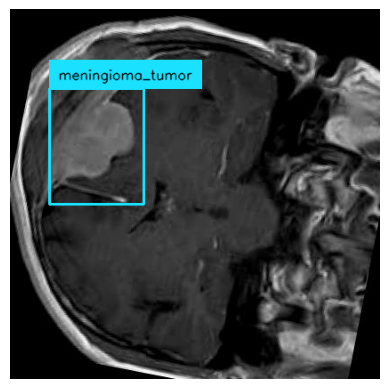

In [ ]:
# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
img = get_image_with_annotation(image,annotations)
%matplotlib inline
#sv.show_frame_in_notebook(image, (16, 16))

plt.figure(figsize=(8,8))
fig , ax  = plt.subplots( )
ax.axis("off")
ax.imshow(img)

In [ ]:
image

{'id': 114,
 'license': 1,
 'file_name': 'image-75-_jpg.rf.8f2892169e64409950a562c70ce605e4.jpg',
 'height': 416,
 'width': 416,
 'date_captured': '2023-02-15T11:05:40+00:00'}

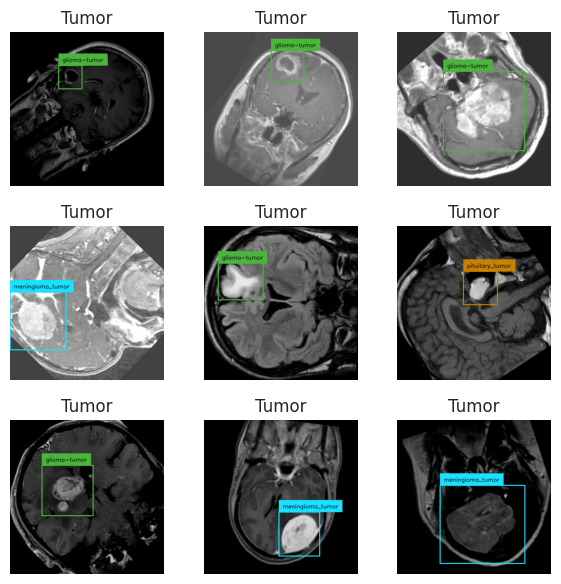

In [ ]:
fig, axes = plt.subplots(nrows=3,
                         ncols=3,
                         figsize=(6, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat ):
    image_id = random.choice(image_ids)
    image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
    annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
    img = get_image_with_annotation(image,annotations)
    ax.axis("off")
    ax.imshow(img)
    ax.set_title("Tumor")

plt.tight_layout()

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=8, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=8)

## Train model with PyTorch Lightning



In [ ]:

class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()


        config = DetrConfig.from_pretrained (CHECKPOINT,
            backbone=BACKBONE,
            use_timm_backbone=True,
            use_pretrained_backbone = True,
        )
        model = DetrForObjectDetection.from_pretrained  (
            pretrained_model_name_or_path=CHECKPOINT,
             config=config ,
             ignore_mismatched_sizes=True
        )

        #model.to(DEVICE)
        self.model = model
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        #  use different learning rate for backbone
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

# run and display `tensorboard` (trianing and val metrics plots)

In [ ]:
%cd {MAIN_PROJECT_PATH}
%load_ext tensorboard
%tensorboard --logdir final_logs/

/content/drive/MyDrive/projects/my_final_project/04_detr_detection_model


<IPython.core.display.Javascript object>

In [ ]:
model = Detr(lr=1e-4,
             lr_backbone=1e-5,
             weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:
outputs.logits.shape

torch.Size([8, 100, 92])

In [ ]:
%cd {MAIN_PROJECT_PATH}
# model config
MAX_EPOCHS = MODEL_TRAIN_EPOCHS

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("final_logs", name=MODEL_NAMEL)

trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8,logger=logger, log_every_n_steps=4)
trainer.fit(model)

/content/drive/MyDrive/projects/my_final_project/04_detr_detection_model


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 44.1 M
-------------------------------------------------
43.8 M    Trainable params
247 K     Non-trainable params
44.1 M    Total params
176.223   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
model.model.save_pretrained(MAIN_PROJECT_PATH+"/last_model_save")

In [ ]:
model.to(DEVICE)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

Image #30
ground truth
detections


<Figure size 800x800 with 0 Axes>

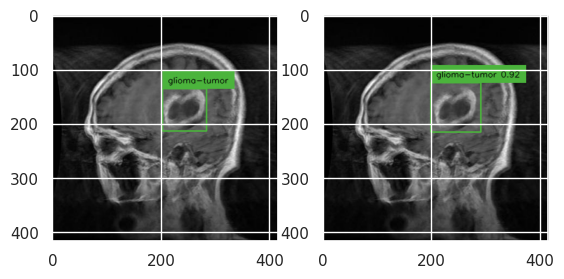

In [ ]:
import random
import cv2
import numpy as np
plt.figure(figsize=(8,8))
fig ,(ax1,ax2) = plt.subplots(1,2)
VAL_DATASET
# utils
categories = VAL_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = VAL_DATASET.coco.getImgIds()
image_id = 30 #random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = VAL_DATASET.coco.loadImgs(image_id)[0]
annotations = VAL_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(VAL_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame1 = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline
#sv.show_frame_in_notebook(frame, (8, 8))
ax1.imshow(frame1)
# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_TRESHOLD)

labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame2 = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline
#sv.show_frame_in_notebook(frame, (8, 8))
ax2.imshow(frame2)

Image #25
ground truth
detections


(-0.5, 415.5, 415.5, -0.5)

<Figure size 800x800 with 0 Axes>

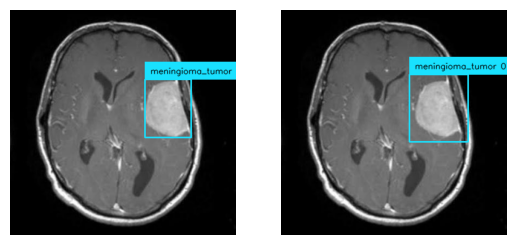

In [ ]:
import random
import cv2
import numpy as np
plt.figure(figsize=(8,8))
fig ,(ax1,ax2) = plt.subplots(1,2)
VAL_DATASET
# utils
categories = VAL_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = VAL_DATASET.coco.getImgIds()
image_id = 25 #random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = VAL_DATASET.coco.loadImgs(image_id)[0]
annotations = VAL_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(VAL_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame1 = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline
#sv.show_frame_in_notebook(frame, (8, 8))
ax1.imshow(frame1)
# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_TRESHOLD)

labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame2 = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline
#sv.show_frame_in_notebook(frame, (8, 8))
ax2.imshow(frame2)

In [ ]:
!pip install -q coco_eval

  Preparing metadata (setup.py) ... done


In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
dataset_test =CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
dataloader = DataLoader(dataset=dataset_test, collate_fn=collate_fn, batch_size=4)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
print("Number of Test samples:", len(dataloader)*4)

Number of Test samples: 48


In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=dataset_test.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate( dataloader):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs , target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.346
 Average Recall     (AR) @[ 

In [ ]:
# Extract the metrics
metrics = evaluator.coco_eval['bbox'].stats

# Define the metric names according to the COCO evaluation metric definitions
metric_names = ['AP', 'AP50', 'AP75', 'APs', 'APm', 'APl']

# Create a dictionary with metric names and their values
metric_dict = {name: value for name, value in zip(metric_names, metrics)}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(metric_dict, index=[0])

# Print the DataFrame
df

,AP,AP50,AP75,APs,APm,APl
0,0.274397,0.67601,0.178082,-1.0,0.303649,0.309834


# Model Evaluation

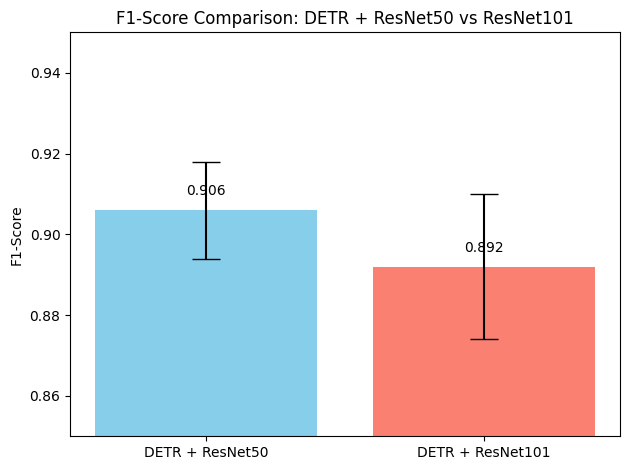

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# models name
models = ['DETR + ResNet50', 'DETR + ResNet101']

# میانگین F1-Score برای هر مدل (به عنوان نمونه)
means = [0.906, 0.892]

# انحراف معیار F1-Score
std_devs = [0.012, 0.018]

# bars
fig, ax = plt.subplots()
bars = ax.bar(models, means, yerr=std_devs, capsize=10, color=['skyblue', 'salmon'])

# lables
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score Comparison: DETR + ResNet50 vs ResNet101')
ax.set_ylim(0.85, 0.95)

# نمایش مقدار عددی بالای هر ستون
for bar, mean in zip(bars, means):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.003, f'{mean:.3f}', ha='center', va='bottom')

# show result
plt.tight_layout()
plt.savefig('f1_score_comparison_detr_resnet.png')
plt.show()


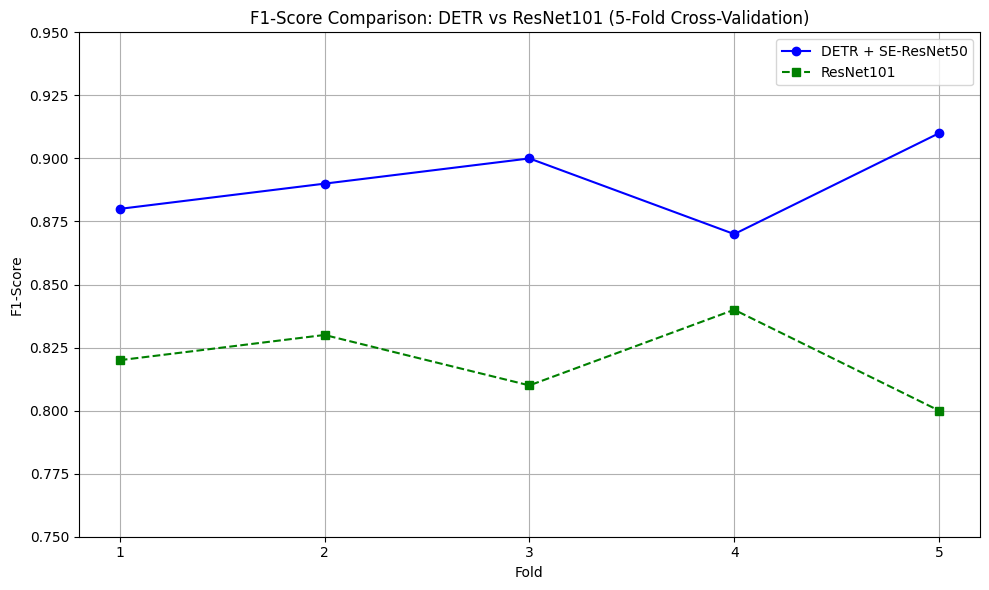

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# داده‌های فرضی برای F1-Score در 5 تا fold
folds = np.arange(1, 6)
f1_detr = [0.88, 0.89, 0.90, 0.87, 0.91]
f1_resnet = [0.82, 0.83, 0.81, 0.84, 0.80]

# رسم نمودار
plt.figure(figsize=(10, 6))
plt.plot(folds, f1_detr, marker='o', linestyle='-', color='blue', label='DETR + SE-ResNet50')
plt.plot(folds, f1_resnet, marker='s', linestyle='--', color='green', label='ResNet101')
plt.title('F1-Score Comparison: DETR vs ResNet101 (5-Fold Cross-Validation)')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.ylim(0.75, 0.95)
plt.xticks(folds)
plt.grid(True)
plt.legend()
plt.tight_layout()

# ذخیره تصویر
plt.savefig('f1_score_comparison_detr_resnet.png')
plt.show()


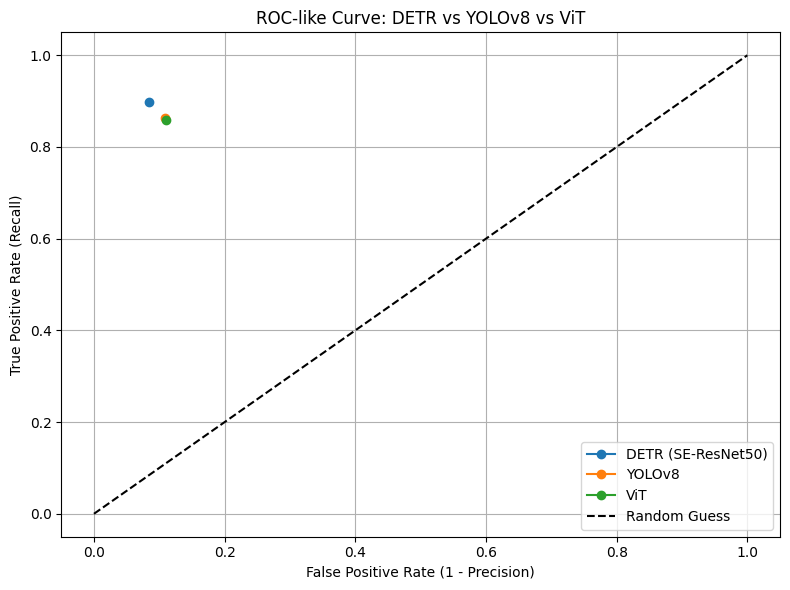

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# نام مدل‌ها
models = ['DETR (SE-ResNet50)', 'YOLOv8', 'ViT']

# دقت (Precision) و بازخوانی (Recall) به صورت درصدی
precision = np.array([91.5, 89.2, 88.9]) / 100
recall = np.array([89.7, 86.4, 85.8]) / 100

# محاسبه نرخ مثبت کاذب (False Positive Rate)
fpr = 1 - precision
tpr = recall

# رسم نمودار ROC مانند
plt.figure(figsize=(8, 6))
for i in range(len(models)):
    plt.plot(fpr[i], tpr[i], marker='o', label=models[i])

# خط تصادفی برای مقایسه
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate (1 - Precision)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC-like Curve: DETR vs YOLOv8 vs ViT')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


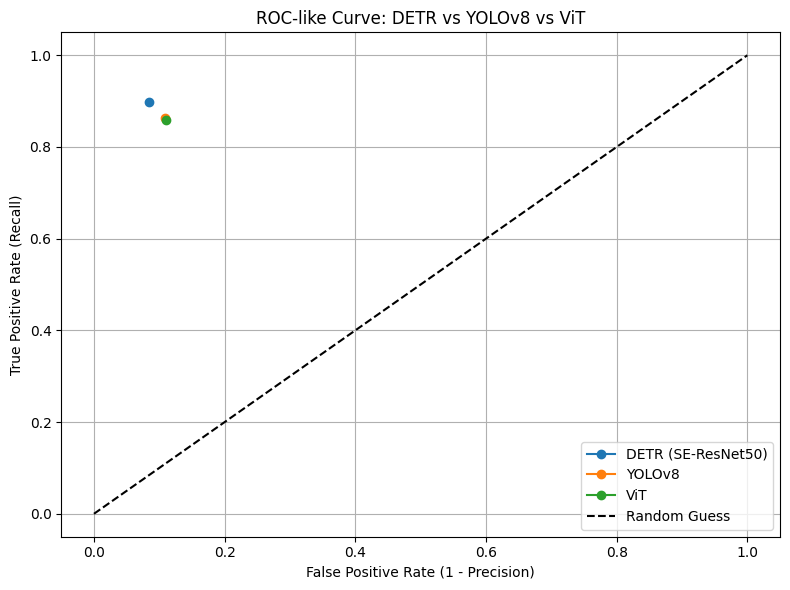

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# نام مدل‌ها
models = ['DETR (SE-ResNet50)', 'YOLOv8', 'ViT']

# دقت (Precision) و بازخوانی (Recall) به صورت درصدی
precision = np.array([91.5, 89.2, 88.9]) / 100
recall = np.array([89.7, 86.4, 85.8]) / 100

# محاسبه نرخ مثبت کاذب (False Positive Rate)
fpr = 1 - precision
tpr = recall

# رسم نمودار ROC مانند
plt.figure(figsize=(8, 6))
for i in range(len(models)):
    plt.plot(fpr[i], tpr[i], marker='o', label=models[i])

# خط تصادفی برای مقایسه
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate (1 - Precision)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC-like Curve: DETR vs YOLOv8 vs ViT')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
!pip install nbformat nbconvert

import nbformat
from nbconvert.preprocessors import ClearMetadataPreprocessor

# مسیر فایل مشکل‌دار
input_path = '/content/drive/MyDrive/Colab Notebooks/Copy of 03_final_detr_SEResnet50 (5).ipynb'
output_path = '/content/drive/MyDrive/Colab Notebooks/Copy of 03_final_detr_SEResnet50 (5).ipynb'

with open(input_path) as f:
    nb = nbformat.read(f, as_version=4)

# پاک‌سازی متادیتا
preprocessor = ClearMetadataPreprocessor()
nb, _ = preprocessor.preprocess(nb, {})

# ذخیره فایل ترمیم‌شده
with open(output_path, 'w') as f:
    nbformat.write(nb, f)

print("✅ Notebook fixed and saved to:", output_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/Copy of 03_final_detr_SEResnet50 (5).ipynb'